In [1]:
import csv
import numpy as np
from spectra import Spectra, Pigment
import matplotlib.pyplot as plt
import numpy.typing as npt

In [2]:
color_file_dict = {
    "": "000",
    "c": "100",
    "m": "010",
    "y": "001",
    "cm": "110",
    "cy": "101",
    "my": "011",
    "cmy": "111"
}

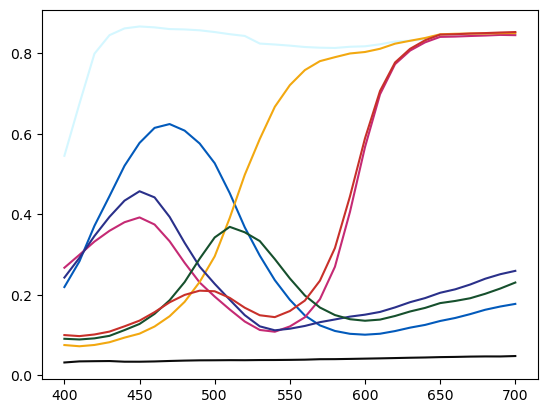

In [3]:
color_spectra_dict = {}
wavelengths = np.arange(400, 701, 10)

for color, fn in color_file_dict.items():
    with open(f'PrintColors/{fn}.csv') as csvf:
        spamreader = csv.reader(csvf, delimiter=';')
        for i, row in enumerate(spamreader):
            if i == 4:
                color_data = np.array(row[33:],dtype=float)
                spectra = Spectra(data=color_data, wavelengths=wavelengths)
                color_spectra_dict[fn] = spectra
                
for spectra in color_spectra_dict.values():
    spectra.plot(color=np.clip(spectra.to_rgb(),0,1))
    
plt.show()

**Demonstration that KM theory is decent for predicting the entirely subtractive case of ink printing**

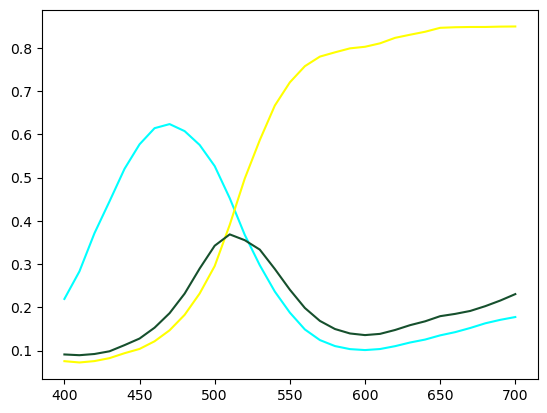

In [4]:
color_spectra_dict["100"].plot(color="cyan")
color_spectra_dict["001"].plot(color="yellow")
color_spectra_dict["101"].plot()
plt.show()

In [5]:
# km mix 
def mix(pigment1: Pigment, pigment2: Pigment, concentrations=None) -> Pigment:
    assert np.array_equal(pigment1.reflectance[:, 0], pigment2.reflectance[:, 0])
    wavelengths = pigment1.wavelengths()

    # todo: interpolate/sample so the wavelength data can be different
    # potential implementation: pass in wavelengths to get_k_s,
    # and then the result will be two lists of length agreeing with len(wavelengths)

    if not concentrations:
        concentrations = [0.5, 0.5]
    k_mix, s_mix = [], []
    for k1, s1, k2, s2 in zip(*pigment1.get_k_s(), *pigment2.get_k_s()):
        k_mix.append(concentrations[0] * k1 + concentrations[1] * k2)
        s_mix.append(concentrations[0] * s1 + concentrations[1] * s2)

    k = np.column_stack((wavelengths, k_mix))
    s = np.column_stack((wavelengths, s_mix))

    return Pigment(k=k, s=s)

<IPython.core.display.Javascript object>


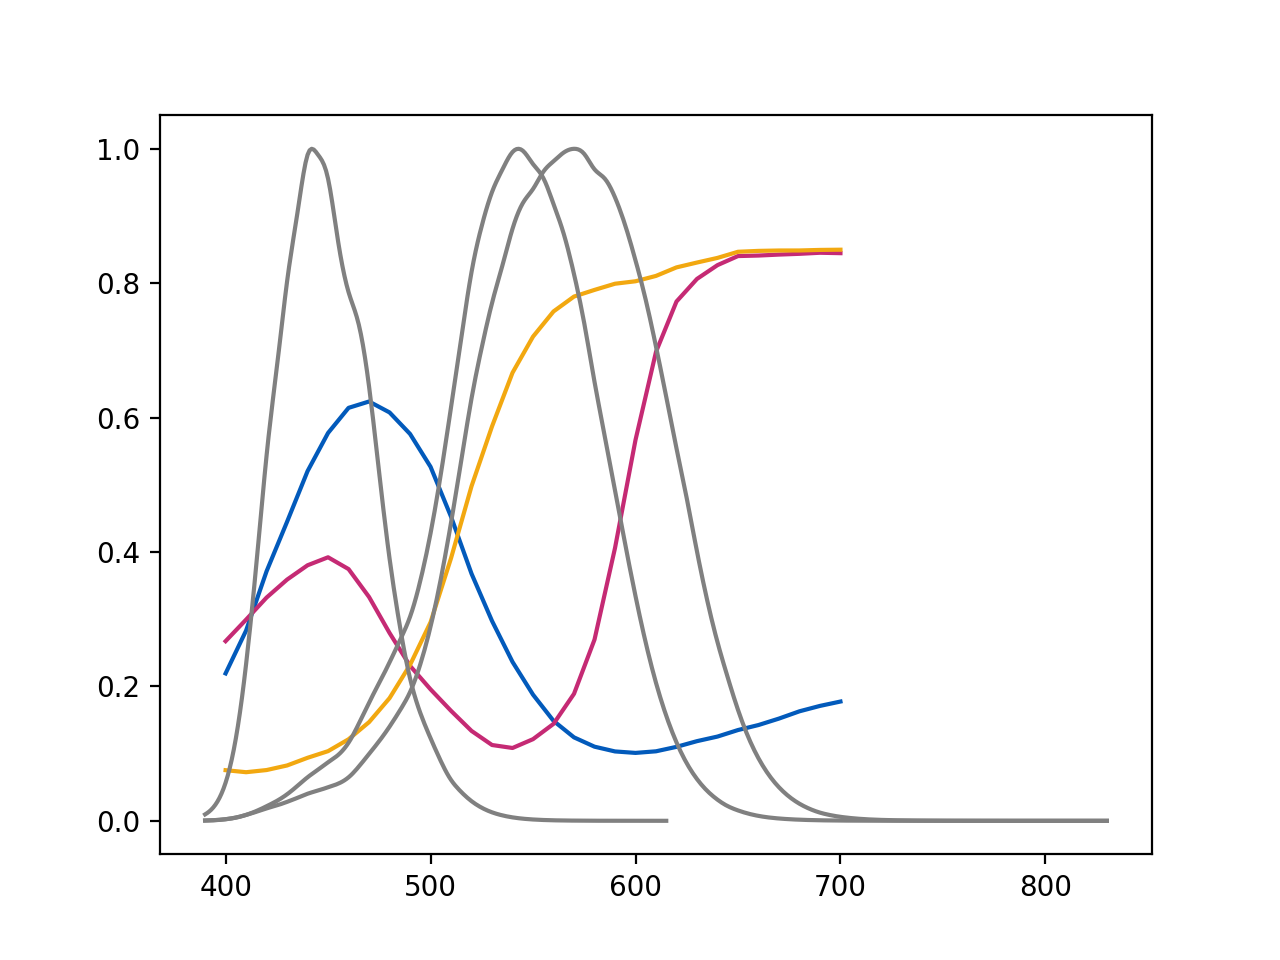

In [25]:
fig5, ax5 = plt.subplots()
color_spectra_dict["100"].plot(ax=ax5)
color_spectra_dict["010"].plot(ax=ax5)
color_spectra_dict["001"].plot(ax=ax5)
s_cone.plot(color='grey')
m_cone.plot(color='grey')
l_cone.plot(color='grey')
plt.show()

In [6]:
cyan_paint = Pigment(reflectance=color_spectra_dict["100"])
yellow_paint = Pigment(reflectance=color_spectra_dict["001"])

In [7]:
green_paint = mix(cyan_paint, yellow_paint)

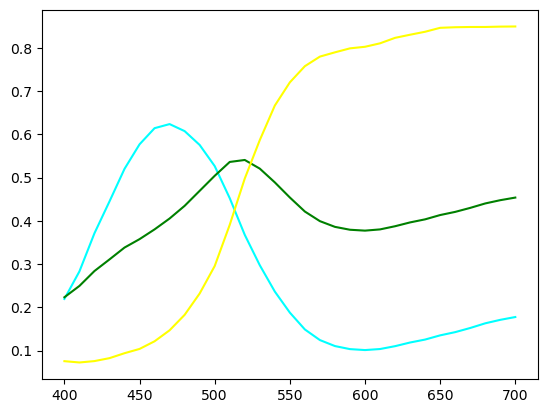

In [8]:
cyan_paint.plot(color="cyan")
green_paint.plot(color="green")
yellow_paint.plot(color="yellow")
plt.show()

In [9]:
def neugebauer_mix(percentages, n=1.8):
    # Yule-Nielsen modifications
    # modified_percentages = percentages**n / (percentages**n + (1 - percentages)**n)
    percentages = np.array(percentages, dtype=float)
    output = Spectra(wavelengths=wavelengths, data=np.zeros_like(wavelengths))
    for key, spectra in color_spectra_dict.items():
        binary_vector = np.array(list(map(int, key)))
        weight = np.prod(binary_vector * percentages + (1 - binary_vector) * (1 - percentages))
        output += weight * (spectra ** (1 / n))
    return (output ** n)


[0.16291947 0.22457726 0.15641787]


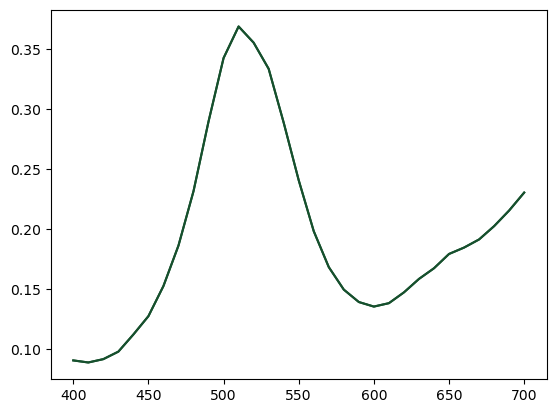

In [10]:
mixed = neugebauer_mix(np.array([1, 0, 1]))
print(mixed.to_xyz()) 
mixed.plot()
color_spectra_dict["101"].plot()
plt.show()

**Visualization**

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull

from typing import List

from metamers import Cone, Observer
from models import gaussian

In [12]:
def plot_pointcloud_hull(points, labels=('S','M','L'), fig=None, ax=None, alpha=1):
    # points in shape M x 3
    hull = ConvexHull(points)
    
    if fig is None or ax is None:  
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])    
    
    
    for simplex in hull.simplices:
        s = simplex.astype(int)
        s = np.append(s, s[0]) 
        ax.plot(points[s,0], points[s,1], points[s,2], "k-", alpha=alpha)
        
            

    return fig, ax



<IPython.core.display.Javascript object>


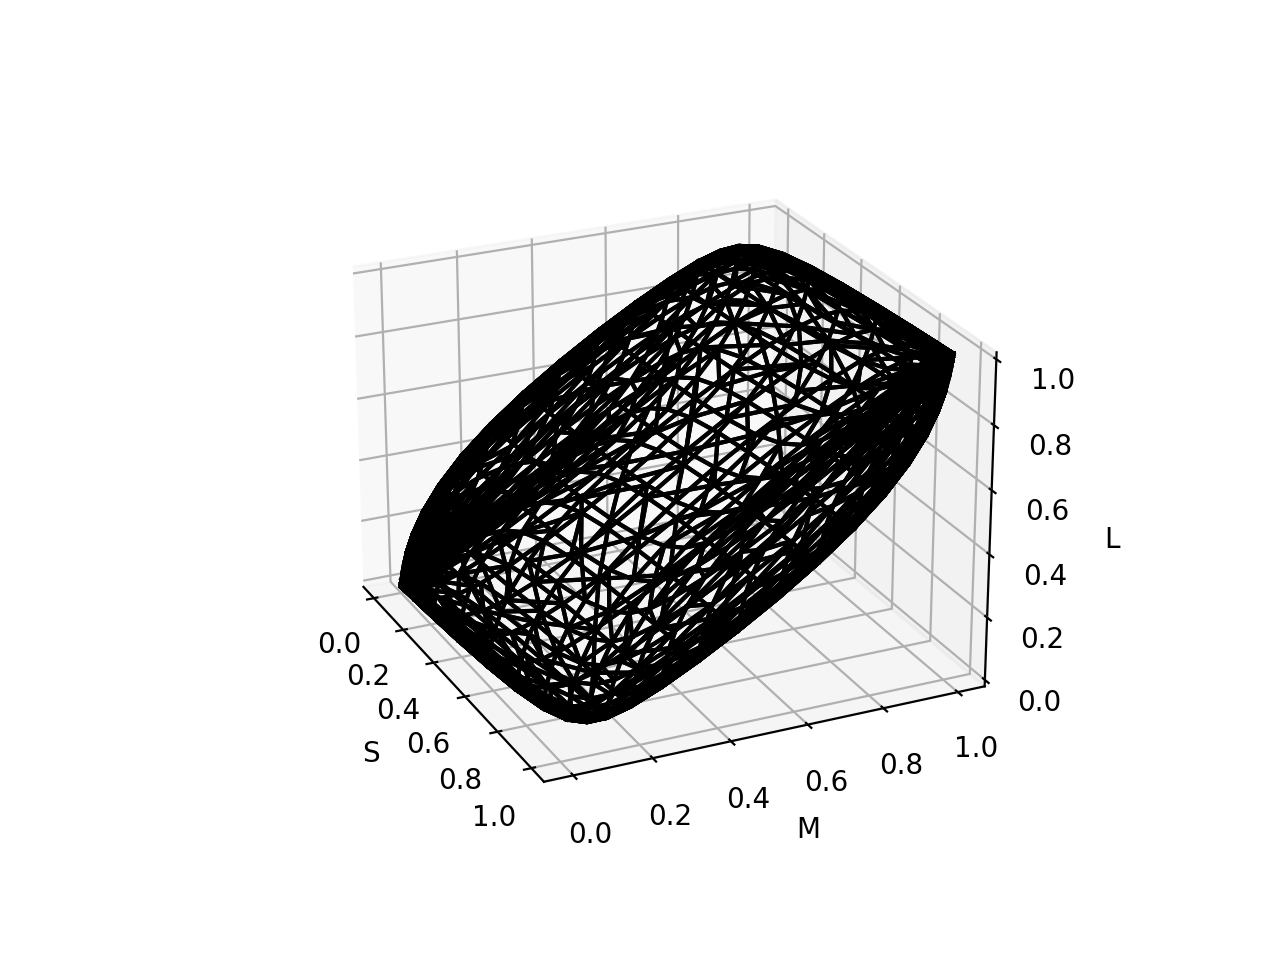

In [13]:
def remove_trailing_nans(arr):
    mask = np.any(np.isnan(arr), axis=1)
    idx = np.where(mask)[0]
    if idx.size > 0:
        last_valid_idx = np.where(~mask)[0][-1]
        return arr[:last_valid_idx + 1]
    return arr

cone_data = np.genfromtxt('linss2_10e_1.csv', delimiter=',')

l_cone = Cone(cone_data[:, [0, 1]])
m_cone = Cone(cone_data[:, [0, 2]])
s_cone = Cone(remove_trailing_nans(cone_data[:, [0, 3]]))

%matplotlib notebook

trichromat = Observer([s_cone, m_cone, l_cone], min_transition_size=10)
TRI_GAMUT_POINTS = trichromat.get_full_colors().T  # M x 3


plot_pointcloud_hull(TRI_GAMUT_POINTS)
plt.show()

In [14]:
from colour import convert


In [15]:
from colour import convert, sRGB_to_XYZ, XYZ_to_sd

pink = np.array((255,192,203)) / 255
green = np.array((0,0,255)) / 255
red = np.array((255, 0, 0)) / 255
orange = np.array((255,127,80)) / 255

new_dyes = [pink, green, red, orange]


b = convert(pink, "sRGB", "Spectral Distribution")
print(b.shape)

(360.0, 780.0, 5.0)


In [16]:
extra

NameError: name 'extra' is not defined

<IPython.core.display.Javascript object>


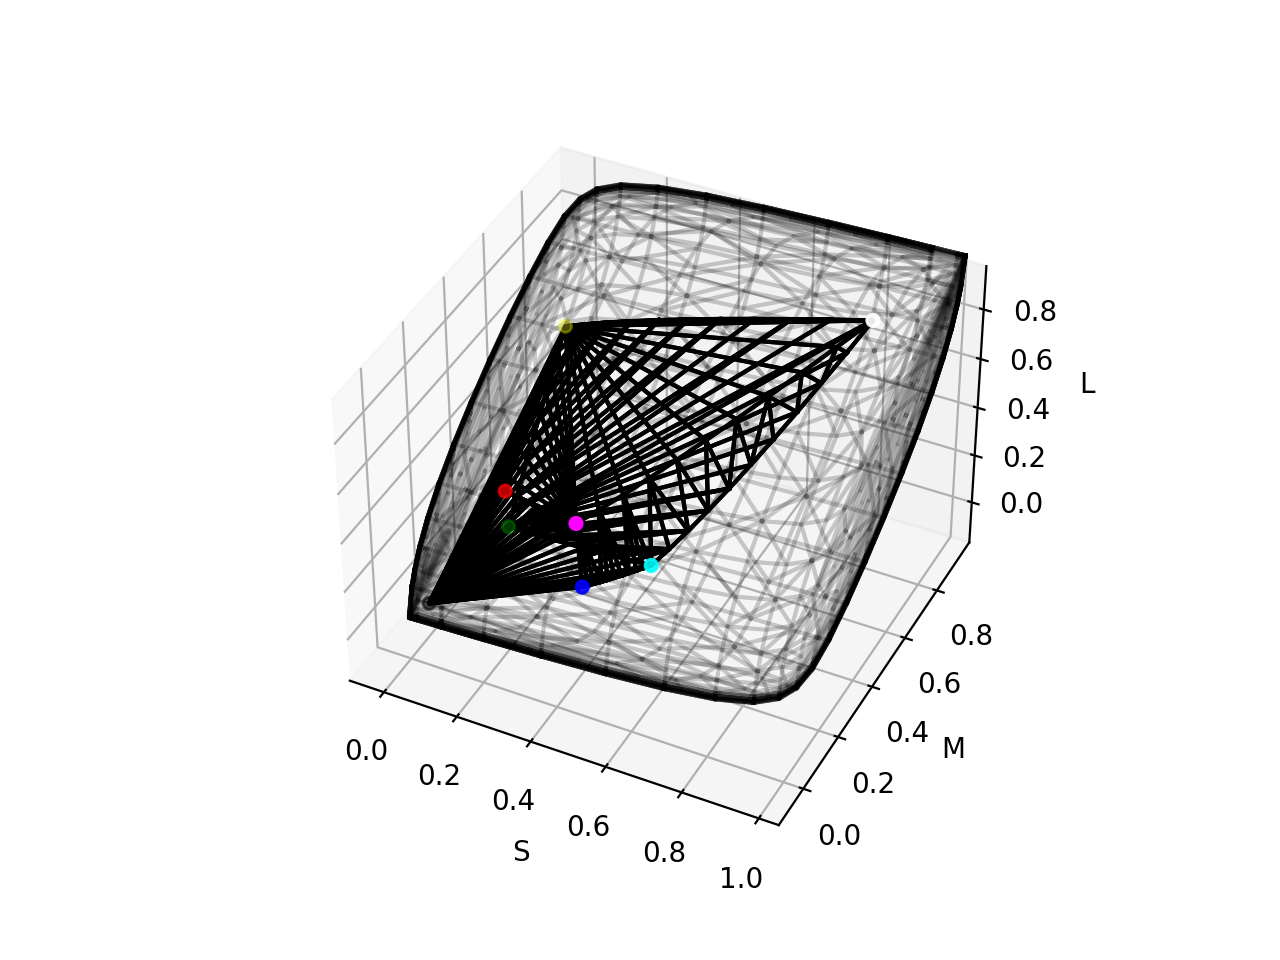

In [17]:
_ink_gamut_points = []

# put c, m, y at start for convenience
_ink_gamut_points.extend(
    [trichromat.observe(spectra) for spectra in color_spectra_dict.values()]
)

for c in np.arange(0, 1.1, 0.1):
    for m in np.arange(0, 1.1, 0.1):
        for y in np.arange(0, 1.1, 0.1):
            mixed_spectra = neugebauer_mix(np.array((c,m,y)))
            tristimulus = trichromat.observe(mixed_spectra)
            _ink_gamut_points.append(tristimulus)

extra = []
for dye in new_dyes:
    b = convert(dye, "sRGB", "Spectral Distribution")
    s = Spectra(data=np.clip(b[list(range(390, 701))], 0, 1), wavelengths=list(range(390,701)))
    tristimulus = trichromat.observe(s)
    extra.append(tristimulus)
    
extra = np.array(extra)
            
INK_GAMUT_POINTS = np.array(_ink_gamut_points)
fig, ax = plot_pointcloud_hull(INK_GAMUT_POINTS)
plot_pointcloud_hull(TRI_GAMUT_POINTS, fig=fig, ax=ax, alpha=0.1)

colors = [
    "white",
    "cyan",
    "magenta",
    "yellow",
    "blue",
    "green",
    "red",
    "black"]

colors2 = [
    "pink", "green", "red", "orange"
]
ax.scatter(INK_GAMUT_POINTS[:8, 0], INK_GAMUT_POINTS[:8, 1], INK_GAMUT_POINTS[:8, 2], c=colors)

#ax.scatter(extra[:,0], extra[:,1], extra[:,2], c=colors2)


plt.show()

In [ ]:
pink_spectra = Spectra(data=b[list(range(390, 700))], wavelengths=list(range(390,700)))

In [ ]:
fig3, ax3 = plt.subplots()
pink_spectra.plot(ax=ax3)

Making a spinning gif

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

image_frames = []

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
# ax.set_box_aspect([1,1,1])
ax.axis('off')


# Rotate and capture frames
for angle in range(0, 360, 2):  # Rotate 360 degrees, 10-degree intervals
    ax.view_init(elev=20, azim=angle)
    plt.draw()
    plt.pause(.001)

    # Capture the current frame
    filename = f'tmp{angle}.png'
    plt.savefig(filename)
    image_frames.append(Image.open(filename))

# Create GIF using PIL
image_frames[0].save('3D_rotation.gif',
                     save_all=True,
                     append_images=image_frames[1:],
                     duration=100,  # milliseconds
                     loop=0)

# Clean up temporary files
import os
for angle in range(0, 360, 2):
    os.remove(f'tmp{angle}.png')


**Finding best Neu. coefficient**

In [ ]:
mixed_samples = {}

In [ ]:
with open(f'PrintColors/inks.csv') as csvf:
    spamreader = csv.reader(csvf, delimiter=';')
    for i, row in enumerate(spamreader):
        if i < 4: continue
        color_data = np.array(row[33:],dtype=float)
        spectra = Spectra(data=color_data, wavelengths=wavelengths)
        mixed_samples[row[4]] = spectra
        

In [ ]:
mixed_samples['33 60 00'].data()

In [ ]:
def compare_spectra(spectra1: Spectra, spectra2: Spectra):
    return np.sum((spectra1.data() - spectra2.data()) ** 2)

In [ ]:
figt, axt = plt.subplots()

l = '55 00 100'

concentrations = np.array(l.split(" "), dtype=float) / 100
theoretical = neugebauer_mix(concentrations, n=1.2)
observed = mixed_samples[l]

compare_spectra(theoretical, observed)
theoretical.plot(ax=axt)
observed.plot(ax=axt, color='r')
fig.show()

In [ ]:
for percentage, observed in mixed_samples.items():
    concentrations = np.array(percentage.split(" "), dtype=float) / 100
    theoretical = neugebauer_mix(concentrations, n=1.5)
    print(percentage, '\t', compare_spectra(theoretical, observed))

In [ ]:
compare_spectra(color_spectra_dict['000'], color_spectra_dict['111'])

Ok think with me here -- what is the space of the LMS gamut in LQMS space? Totally flat. Hrmmm. E.g. ... whatever. 
The point is that the ink gamut, if it demontrated weird behaviour... anyway. time to bash it out.!

**Quick metameric interlude**

In [ ]:
def intersects_triangle(o, d, v0, v1, v2, eps=1e-6):
    e1 = v1 - v0
    e2 = v2 - v0
    
    h = np.cross(d, e2)
    
    a = np.dot(e1, h)
    
    # Check if ray is parallel to triangle
    if a > -eps and a < eps:
        return False, None
    
    f = 1.0 / a
    s = o - v0
    u = f * np.dot(s, h)
    
    if u < 0.0 or u > 1.0:
        return False, None
    
    q = np.cross(s, e1)
    v = f * np.dot(d, q)
    
    # Check for intersection
    if v < 0.0 or u + v > 1.0:
        return False, None
    
    t = f * np.dot(e2, q)
    
    if t > eps:
        return True, t
    else:
        return False, None


In [ ]:
def intersects_hull(o, d, points):
    hull = ConvexHull(points)
    intersection_indices = []
    
    for simplex in hull.simplices:
        vertices = [points[idx] for idx in simplex]
        hit, t = intersects_triangle(o, d, *vertices)
        if hit:
            print(simplex)
            distances = [np.linalg.norm((o + t *d) - v) for v in vertices]
            # todo: could implement an interpolation approach
            
            closest_idx = np.argmin(distances)
            closest_vertex_idx = simplex[closest_idx]
            intersection_indices.append(closest_vertex_idx)
    return intersection_indices

In [ ]:
o = np.array([0.4, 0.3, 0])
d = np.array([0,0,1])
a = intersects_hull(o,d, INK_GAMUT_POINTS)
print(a)

ok at least this result is coherent. 